# Import Libraries

In [1]:
# For metadata/feature processing
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import os
import shutil

# For neural network
import tensorflow as tf

# For Accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# For image
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Uncompress Data

In [2]:
import zipfile

def unzip(src, dst):
    with zipfile.ZipFile(src, 'r') as zf:
        files = zf.namelist()
        with tqdm(total=len(files), desc='Extracting') as pbar:
            for file in files:
                zf.extract(file, dst)
                pbar.update(1)

                
# Remove old directory
# shutil.rmtree('/kaggle/dogs-vs-cats')


# New directory
os.makedirs('/kaggle/dogs-vs-cats', exist_ok=True)

# Train
unzip('/kaggle/input/dogs-vs-cats/train.zip', '/kaggle/dogs-vs-cats/')

# Test
unzip('/kaggle/input/dogs-vs-cats/test1.zip', '/kaggle/dogs-vs-cats/')

Extracting:   0%|          | 0/25001 [00:00<?, ?it/s]

Extracting:   0%|          | 0/12501 [00:00<?, ?it/s]

In [3]:
!tree /kaggle/dogs-vs-cats -L 1

/kaggle/dogs-vs-cats
├── test1
└── train

2 directories, 0 files


# Meta Data
Not all dataset comes with prepared **metadata** (csv file containing file/image/feature/label info). Thus we need to learn how to prepare one for a custom dataset.

## Get Image Paths
First we'll use `glob` to access the file paths of each image to link them to their labels and data split.



In [4]:
paths = glob('/kaggle/dogs-vs-cats/train/*jpg')
print(f"Num Train: {len(paths)}")

test_paths = glob('/kaggle/dogs-vs-cats/test1/*jpg')
print(f"Num Test: {len(test_paths)}")

Num Train: 25000
Num Test: 12500


## Build DataFrame (CSV File)

In [5]:
print('Train:')
df = pd.DataFrame(paths, columns=['image_path'])
display(df.head(2))

print('Test:')
test_df = pd.DataFrame(test_paths, columns=['image_path'])
display(test_df.head(2))

Train:


image_path
0   /kaggle/dogs-vs-cats/train/dog.890.jpg
1  /kaggle/dogs-vs-cats/train/dog.1178.jpg

Test:


image_path
0  /kaggle/dogs-vs-cats/test1/10435.jpg
1   /kaggle/dogs-vs-cats/test1/6790.jpg

# Sample from Data
To reduce time we've down sampled the data. If you are welcome to run on the full dataset. To do so, simply comment out the cell.

In [6]:
# df = df.sample(2500, random_state=42)
# test_df = test_df.sample(2000, random_state=42)

# Retreive Metadata
In the following cell we'll retreive `train-test` split and `class` infomation from **image path**. 


In [7]:
# First we map the class name from the image paths, similar to how it is done in the above code
# Train
df['class_name'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[0]) # extract class

display(df.head(2))

image_path class_name
0   /kaggle/dogs-vs-cats/train/dog.890.jpg        dog
1  /kaggle/dogs-vs-cats/train/dog.1178.jpg        dog

In [8]:
## Similarly, we get the split
# df['split'] = df.image_path.map(lambda x: x.split('/')[-3]) # extract data split
# display(df.head(2))

# Test
# test_df['class_label'] = test_df.image_path.map(lambda x: int(x.split('/')[-2]))  # extract class
# test_df['split'] = test_df.image_path.map(lambda x: x.split('/')[-2])  # extract data split

# display(test_df.head(2))

In [9]:
name2label = {k: v for v, k in enumerate(sorted(df['class_name'].unique()))}
name2label

{'cat': 0, 'dog': 1}

In [10]:
label2name = {v: k for k, v in name2label.items()}
label2name

{0: 'cat', 1: 'dog'}

Now we map the class_labels to the number

In [11]:
# transforming the labels
df['class_label'] = df['class_name'].map(name2label)
display(df.head(2))

image_path class_name  class_label
0   /kaggle/dogs-vs-cats/train/dog.890.jpg        dog            1
1  /kaggle/dogs-vs-cats/train/dog.1178.jpg        dog            1

## Retreiver `id` column

In [12]:
df['id'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[1]) # extract id
display(df.head(2))


test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0]) # extract id
display(test_df.head(2))

image_path class_name  class_label    id
0   /kaggle/dogs-vs-cats/train/dog.890.jpg        dog            1   890
1  /kaggle/dogs-vs-cats/train/dog.1178.jpg        dog            1  1178

image_path     id
0  /kaggle/dogs-vs-cats/test1/10435.jpg  10435
1   /kaggle/dogs-vs-cats/test1/6790.jpg   6790

# Data Split

We create the train and validation split by using the `train_test_split` library from `skleaarn.model_selection`

In this case, we kept the validation data size 30% of the total data

In [13]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"Train: {len(train_df)}")
print(f"Valid: {len(valid_df)}")

Train: 17500
Valid: 7500


# Data Validation

Before diving deeper into the analysis, it's crucial to ensure that our metadata – including path and label – aligns accurately with the actual data. Any discrepancies may lead to inaccurate results, undermining the integrity of our findings.


## Utility

In [14]:
# opencv (cv2) is used for loading image
def load_image(path):
    img = cv2.imread(path, -1) # `-1` means load image as it is, thus no gray to rgb conversion
    img = img[...,::-1] # bgr to rgb
    return img

## One Sample

## Image Shape: (238, 316, 3)
## Label: 1
## Name: dog


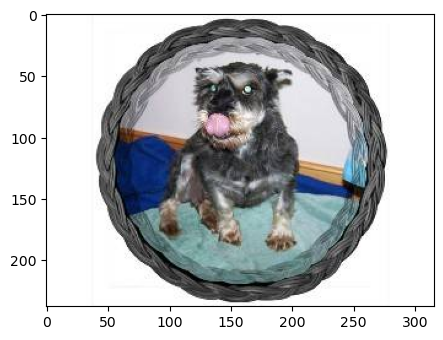

In [15]:
row = train_df.iloc[20]
img = load_image(row.image_path)
print(f"## Image Shape: {img.shape}")
print(f"## Label: {row.class_label}")
print(f'## Name: {row.class_name}')

plt.figure(figsize=(5,5))
plt.imshow(img);

## Multiple Samples

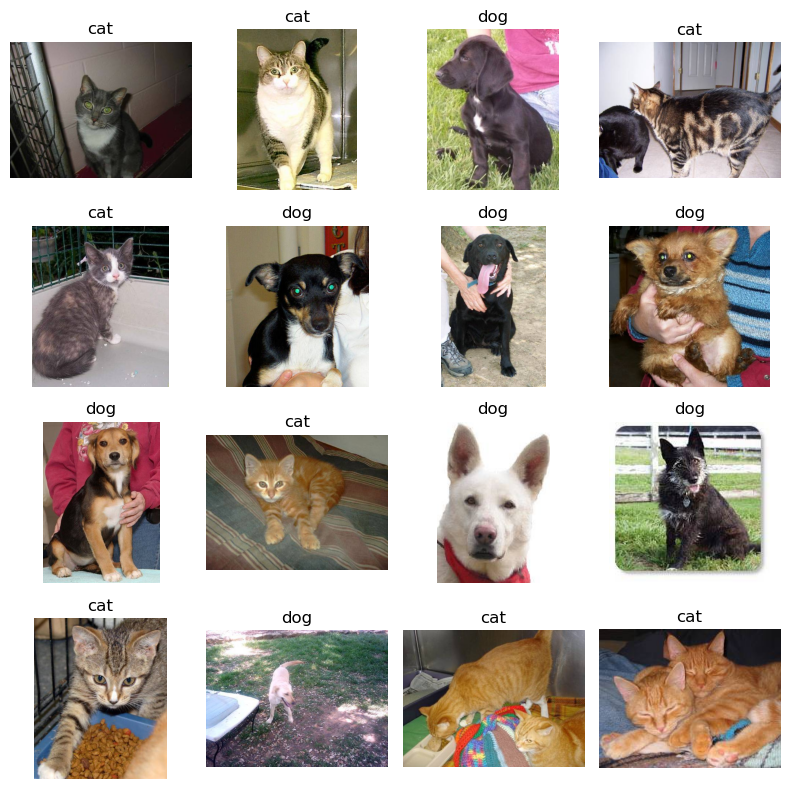

In [16]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(grid_size**2):
    # Generate random index
    img_idx = np.random.randint(0, len(train_df))
    row = train_df.iloc[img_idx]
    
    # Load the image using your preferred method (not implemented here)
    img = load_image(row.image_path)

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(str(row.class_name))
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Data Loader
Processing large datasets that consume a significant amount of memory can be challenging. Thus loading full data on memory is not feasible. Thus our previously used code format like this is not useful,

```python
X, y = np.load('some_training_set_with_labels.npy')

# Build model
model = LinearRegression()

# Train model on dataset, where all the data is loaded on memory at once
model.fit(x=X, y=y)
```
Moreover, traditional methods may not have enough memory to handle the data effectively. In such cases, batching, which involves dividing the dataset into smaller subsets or batches, can be employed to process the data efficiently. By generating and batching datasets using multiple cores in real-time, it becomes possible to seamlessly integrate them with deep learning models.

This dataloader can also handle the cases when label is not available (the test dataset where the images are available but there is no label). This makes it suitable for both training and testing.

The two cases (`label is not None` and `label is None`) are handled within the Dataloader code using `if` condition.

To be more specific, handling the `label is not None` case and keeping the `label is None` as the default case is adequate here

In [17]:
import albumentations as A

class DataLoader(tf.keras.utils.Sequence):
    """
    Custom data loader for Keras model training.
    Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Args:
        paths (list): List of file paths for the images.
        labels (list): List of corresponding labels for the images. 
                       Set labels= None if you are infering on test dataset (where you dont have labels)
        batch_size (int): Number of samples per batch.
        num_classes (int): Number of classes in the dataset.
        dim (tuple): Dimensions of the input images.
        shuffle (bool): Whether to shuffle the data after each epoch.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(index): Generates one batch of data.
        on_epoch_end(): Updates indexes after each epoch.
        __data_generation(batch_indexes): Generates data for a batch.
    """

    def __init__(self, paths, labels=None, batch_size=32, num_classes=1,
                 dim=(128, 128), shuffle=True, augment=False, augment_fn=None):
        """Initialization method for the DataLoader class."""
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        
        # For augmentation
        self.augment = augment
        self.augment_fn = augment_fn
        if self.augment and self.augment_fn is None:
            self.augment_fn = A.Compose([A.HorizontalFlip(p=0.5),
                                         A.RandomBrightnessContrast(p=0.5),
                                         A.Rotate(limit=30, p=0.5)])
                                        
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        batch = self.__data_generation(batch_indexes)

        return batch

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        if self.labels is not None:
            y = np.empty((self.batch_size), dtype=np.float32)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load image
            img = load_image(self.paths[idx])
            
            # Resize image as not all images are with same shape
            img = cv2.resize(img, dsize=self.dim)             
            
            # Apply augmentation
            if self.augment:
                img = self.augment_fn(image=img)["image"]
                
            # Store sample
            X[i,] = img

            # Store class
            if self.labels is not None:
                y[i] = self.labels[idx]

        # Flatten the image pixels for Dense layer
#         X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0

        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.labels is not None:
#             y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            y = y.reshape(-1, 1)
            return X, y
        
        # if there is labels = None, then only return X
        return X

## Loader check

In [18]:
paths = train_df.image_path.tolist()
labels = train_df.class_label.tolist()

train_loader = DataLoader(paths, labels, batch_size=16, augment=True)

imgs, tars = train_loader.__getitem__(0)
print("Images:\n", imgs.shape)

print("\nLabels:\n", tars.shape)

Images:
 (16, 128, 128, 3)

Labels:
 (16, 1)


## Visualize Loader

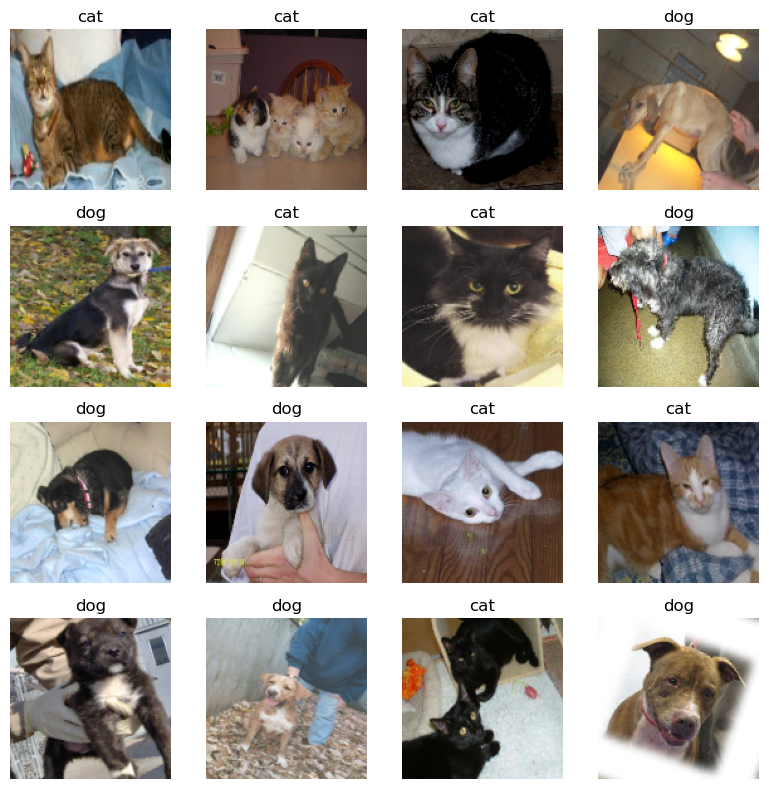

In [19]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(16):
    
    # Load the image
    img = imgs[i] # images are feed as flatten to models
    
    # Get Label
    tar = int(tars[i]>0.5) # label is one hot encoded
    name = label2name[tar]

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(name)
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Normalization Layers

Normalization in deep learning is a technique used to standardize the inputs of a model. It's used to adjust the scales of features to a standard and consistent range, which usually helps speed up the learning process and often improves the final performance of the model.

When we apply normalization to a model, we're trying to mitigate the problems that occur due to the scales of input features differing widely. This could cause the model to give undue importance to some features while neglecting others.

## Why Use Normalization Inside the Model?

There are two primary reasons to use normalization layers inside a model, even when we can normalize the images from the outside:

1. **Covariate Shift**: Covariate shift refers to the change in input distribution during training. Normalizing the inputs can make the model invariant to the scale of the features, and hence more robust to the variations in input distribution. Normalizing the features within the model helps handle covariate shift as the model trains over time.

2. **Internal Covariate Shift**: This is a more specific problem in deep learning where the distribution of layer inputs changes during training, as the parameters of the previous layers change. This can slow down training and make it harder for the network to converge. Normalization layers inside the model address this issue.

> "Covariate Shift" refers to the situation where the distribution of input data to a model changes between the training phase and the testing (or deployment) phase. It's a problem because machine learning models assume that the training data and the test data are drawn from the same distribution.

## Different Types of Normalization Layers

Different types of normalization layers include:

1. **Batch Normalization**: This method normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This can help speed up learning in deep neural networks by reducing internal covariate shift.

$$y_i = γ \left( \frac{x_i - μ_B}{\sqrt{σ_B² + ε}} \right) + β$$

Here:

- $x_i$ is an input,
- $y_i$ is the corresponding output,
- $μ_B$ is the mean of the mini-batch B aka `moving_mean`,
- $σ_B²$ is the variance of the mini-batch B aka `moving_variance`,
- $γ$ and $β$ are learnable parameters (scale and shift),
- $ε$ is a constant for numerical stability (typically a very small number).


2. **Layer Normalization**: Unlike batch normalization which normalizes along the batch dimension, layer normalization normalizes along the feature dimension. It computes the mean and variance used for normalization from all of the summed inputs to the neurons in a layer on a single training case.

3. **Instance Normalization**: This is also called contrast normalization and is used primarily in style transfer (generative adversarial networks). It normalizes the features in each individual example in the same way batch normalization normalizes features in each batch.

4. **Group Normalization**: Group normalization divides the channels into smaller groups and normalizes the features within each group. It's designed to perform well in a wide range of contexts, including both small and large batch sizes.

<img src="https://theaisummer.com/static/ac89fbcf1c115f07ae68af695c28c4a0/b97f6/normalization.png">

> Normalization layers should be used when the scale of input features differs widely, or when training deep neural networks to help reduce internal covariate shift and speed up learning. 

In [20]:
# Instantiate a batch normalization layer
bn = tf.keras.layers.BatchNormalization()

# Inputs
inp = tf.random.uniform(shape=(1, 32, 32, 3))

# The forward pass
out = bn(inp)

# shapes
inp.shape, out.shape

(TensorShape([1, 32, 32, 3]), TensorShape([1, 32, 32, 3]))

In [21]:
bn.weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_mean:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_variance:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>]

In [22]:
bn.get_weights()

[array([1., 1., 1.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([1., 1., 1.], dtype=float32)]

# AlexNet

**Performance compared to ML models**

<img src="https://www.researchgate.net/publication/346091812/figure/fig2/AS:979480482938881@1610537753860/Algorithms-that-won-the-ImageNet-Large-Scale-Visual-Recognition-Challenge-ILSVRC-in.png" width="700">


**Architecture**

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/0*pJ3o_2zTTNnixhKH.png" width="800">

**Major Contributions of AlexNet:**

1. **Introduction of Deep Learning:** AlexNet introduced a deeper and wider model compared to previous networks, setting the stage for future deep learning models.
2. **Convolutional Layers:** AlexNet popularized the use of convolutional layers to process input images in chunks, which improved performance and efficiency.
3. **ReLU Activation Function:** AlexNet was the first to use ReLU (Rectified Linear Unit) as its activation function, accelerating the training speed significantly compared to traditional activation functions.
4. **GPU Usage:** AlexNet made efficient use of GPUs for its computations, making it feasible to train deep networks.

---

**Pros and Cons of AlexNet:**

| Pros | Cons |
|---|---|
| Pioneered deep learning, starting the trend of deeper networks | Requires substantial computational resources, primarily a GPU, for training |
| ReLU activation function increased training speed | Has many hyperparameters that need to be tuned |
| Utilized GPU for computations, thus speeding up the training process | Larger than necessary for many simpler tasks |
| Showed impressive results on ImageNet, thus proving the potential of deep networks | Overfitting risk due to its complexity |


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout

def AlexNet(input_shape=(224, 224, 3), num_classes=1, lr=1e-3):
    # Input layer
    inp = Input(shape=input_shape)

    # 1st Convolutional Layer
    x = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='same')(inp)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

    # 2nd Convolutional Layer
    x = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

    # 3rd Convolutional Layer
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)

    # 4th Convolutional Layer
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)

    # 5th Convolutional Layer
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

    # Fully Connected layer
    x = Flatten()(x)
    x = Dense(128)(x)  # 4096 for AlexNet
    x = Activation('relu')(x)
#     x = Dropout(0.4)(x)  # uncomment for AlexNet

#     # 2nd Fully Connected Layer
#     x = Dense(4096)(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.4)(x)

    # Output Layer
    out = Dense(num_classes, activation='sigmoid')(x)

    # Instantiate and return the model
    model = Model(inputs=inp, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    return model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        34944     
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 16, 16, 256)       0         
                                                             

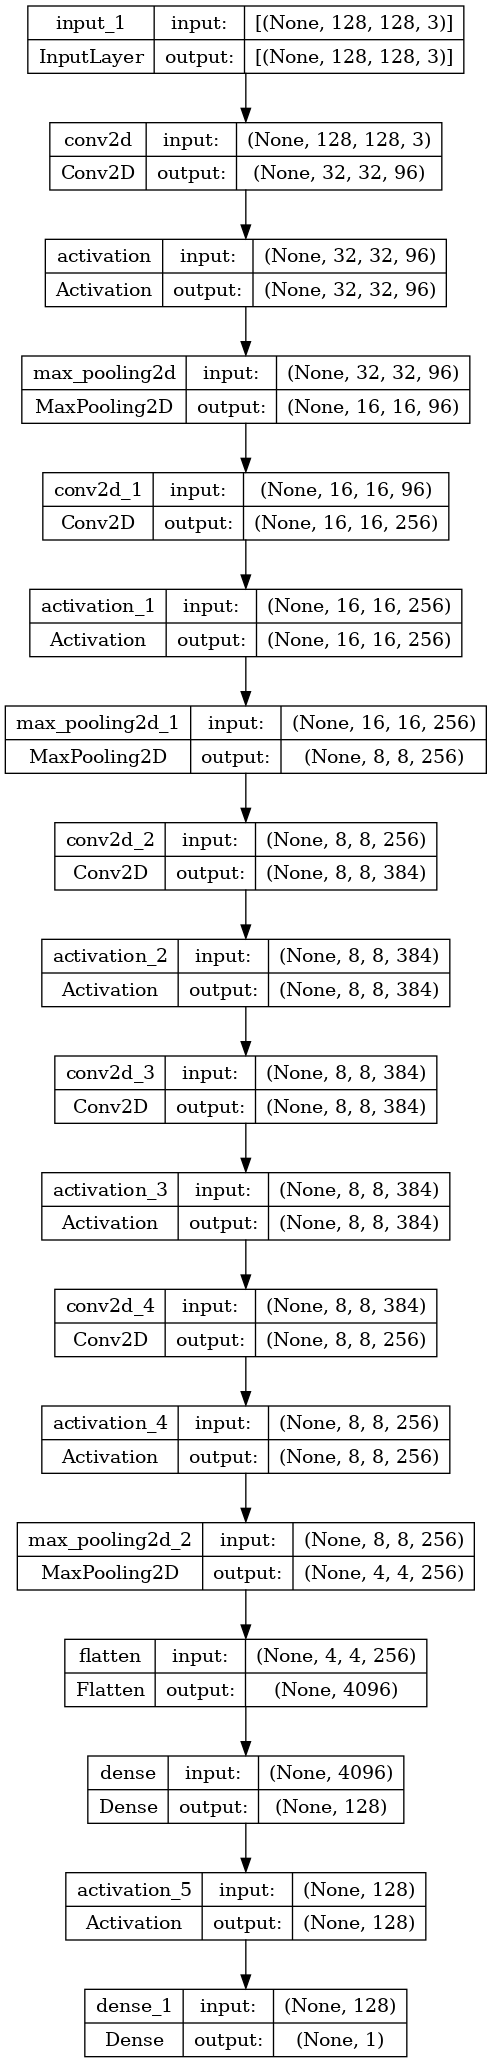

In [24]:
# Use function to create a model
model = AlexNet(input_shape=(128, 128, 3), num_classes=1)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

## Check Feed Forward

In [25]:
out = model(imgs)
out.shape

TensorShape([16, 1])

## Training

In [26]:
# Step 1: Get train-test image paths and labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['class_label'].tolist()

valid_paths = valid_df['image_path'].tolist()
valid_labels = valid_df['class_label'].tolist()

# Step 2: Data loader
train_loader = DataLoader(train_paths, train_labels, batch_size=128, augment=False)

valid_loader = DataLoader(valid_paths, valid_labels, batch_size=128, shuffle=False)


# Step 3: Build the model
model = AlexNet(input_shape=(128, 128, 3), num_classes=1, lr=0.5e-3)

# Step 4: Model training
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/best_ckpt.h5',
                                             monitor = 'val_accuracy',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max') # to save best scoring model

print('## Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=15,
                    verbose=1,
                    callbacks=[ckpt_cb])

# Step 5: Predict on test data

## Load best model
model = tf.keras.models.load_model('/kaggle/working/best_ckpt.h5') # you can save model using model.save()

print("\n## Inference")
valid_loader = DataLoader(valid_paths, valid_labels, batch_size=100, shuffle=False)
predictions = model.predict(valid_loader)[:len(valid_df)]

# Step 6: Measure performance
acc = accuracy_score(valid_labels, (predictions > 0.5).astype(int))
print(f"\n## Accuracy: {acc}")

## Training
Epoch 1/15
137/137 [==============================] - 98s 675ms/step - loss: 0.6712 - accuracy: 0.5761 - val_loss: 0.6557 - val_accuracy: 0.6271
Epoch 2/15
137/137 [==============================] - 90s 656ms/step - loss: 0.6128 - accuracy: 0.6663 - val_loss: 0.5888 - val_accuracy: 0.7005
Epoch 3/15
137/137 [==============================] - 92s 670ms/step - loss: 0.5454 - accuracy: 0.7249 - val_loss: 0.5224 - val_accuracy: 0.7393
Epoch 4/15
137/137 [==============================] - 91s 668ms/step - loss: 0.4886 - accuracy: 0.7619 - val_loss: 0.5048 - val_accuracy: 0.7545
Epoch 5/15
137/137 [==============================] - 90s 655ms/step - loss: 0.4420 - accuracy: 0.7904 - val_loss: 0.4509 - val_accuracy: 0.7887
Epoch 6/15
137/137 [==============================] - 90s 659ms/step - loss: 0.3916 - accuracy: 0.8195 - val_loss: 0.4612 - val_accuracy: 0.7871
Epoch 7/15
137/137 [==============================] - 90s 654ms/step - loss: 0.3423 - accuracy: 0.8483 - val_loss: 0.4

## Plot History

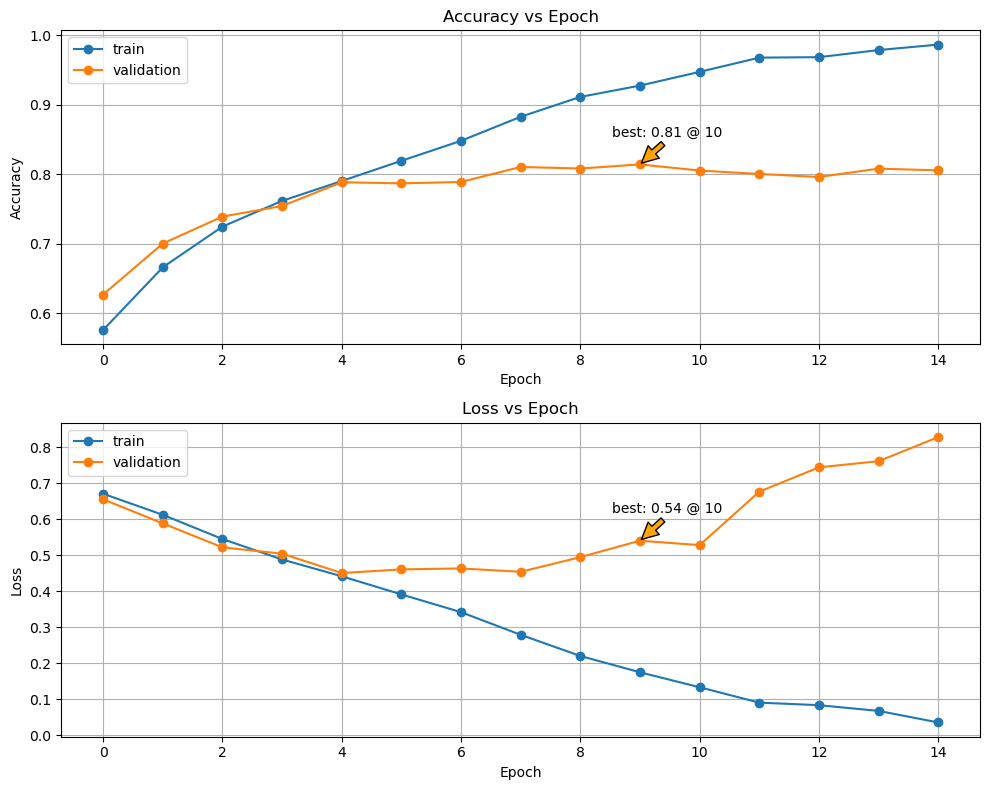

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], '-o')
    plt.plot(history.history['val_accuracy'], '-o')
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation accuracy is max
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc)
    plt.annotate(f'best: {best_val_acc:.2f} @ {best_val_acc_epoch+1}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-o')
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation loss is min
    best_val_loss_epoch = best_val_acc_epoch
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.annotate(f'best: {best_val_loss:.2f} @ {best_val_loss_epoch+1}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    plt.tight_layout()
    plt.show()
    
# Plot history of training
plot_history(history)

## Result Analysis

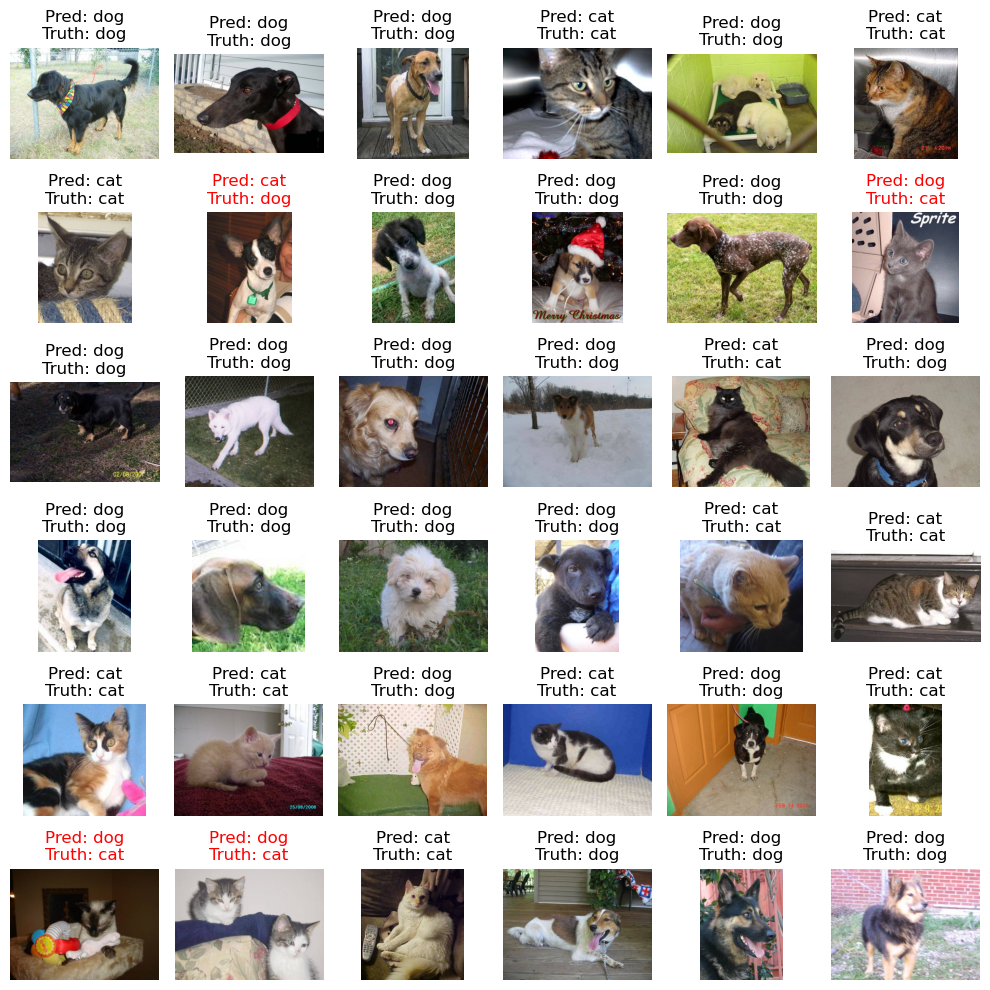

In [28]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
# indices = np.random.choice(len(valid_paths), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(range(num_images)):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image_path = valid_paths[idx]
    image = load_image(image_path)  # Load and preprocess single image
    
    # Get prediction and ground truth
    pred = (predictions[idx]>0.5).astype(int)[0]
    pred = label2name[pred] # 0 -> cat
    true = valid_labels[idx]
    true = label2name[true] # 0 -> cat

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

    if pred == true:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}')
    else:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}', color='red')

plt.tight_layout()
plt.show()


# VGG


**Major Contributions of VGG Network:**

1. **Uniform Architecture:** VGG demonstrated that using small (3x3) convolution filters in a deep network can achieve excellent performance.
2. **Depth Importance:** VGG showed the importance of depth in a network. It included 16-19 layers and outperformed shallower architectures.
3. **Transfer Learning:** VGG models, due to their excellent generalization capabilities, have been widely used for transfer learning.


**Achitecture**

<img src="https://iq.opengenus.org/content/images/2019/01/vgg_layers.png" width="700">

---

**Pros and Cons of VGG Network:**

| Pros | Cons |
|---|---|
| Demonstrated the power of depth in neural networks | Very resource-intensive due to its depth |
| Simple and uniform architecture is easy to understand | Longer training times due to the large number of layers |
| Excellent for transfer learning due to good feature generalization | Requires more memory due to the number of parameters |
| Good performance on object recognition tasks | Overfitting risk due to its complexity and depth |


**AlexNet Vs VGG**

| Features | AlexNet | VGG |
|---|---|---|
| **Depth** | Has 8 layers (5 convolutional and 3 fully connected layers) | Deeper networks with 16-19 layers |
| **Architecture** | Varies the size of convolution filters (11x11, 5x5, 3x3) | Uniform architecture using small (3x3) convolution filters |
| **Usage of ReLU** | First to use ReLU activation function | Also uses ReLU, but not the first |
| **Size** | Smaller, with around 60 million parameters | Larger, with around 138 million parameters in VGG16 and 144 million in VGG19 |
| **Training Speed** | Faster due to less depth | Slower because of deeper architecture |
| **Transfer Learning** | Less commonly used for transfer learning | Excellent for transfer learning due to better generalization of features |

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout

def VGG16_S(input_shape=(224, 224, 3), num_classes=1, lr=0.5e-3):
    # Input layer
    inp = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inp)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # FC layers
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # Output Layer
    out = Dense(num_classes, activation='sigmoid')(x)

    # Instantiate and return the model
    model = Model(inputs=inp, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    return model


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 activation_12 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 activation_13 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                           

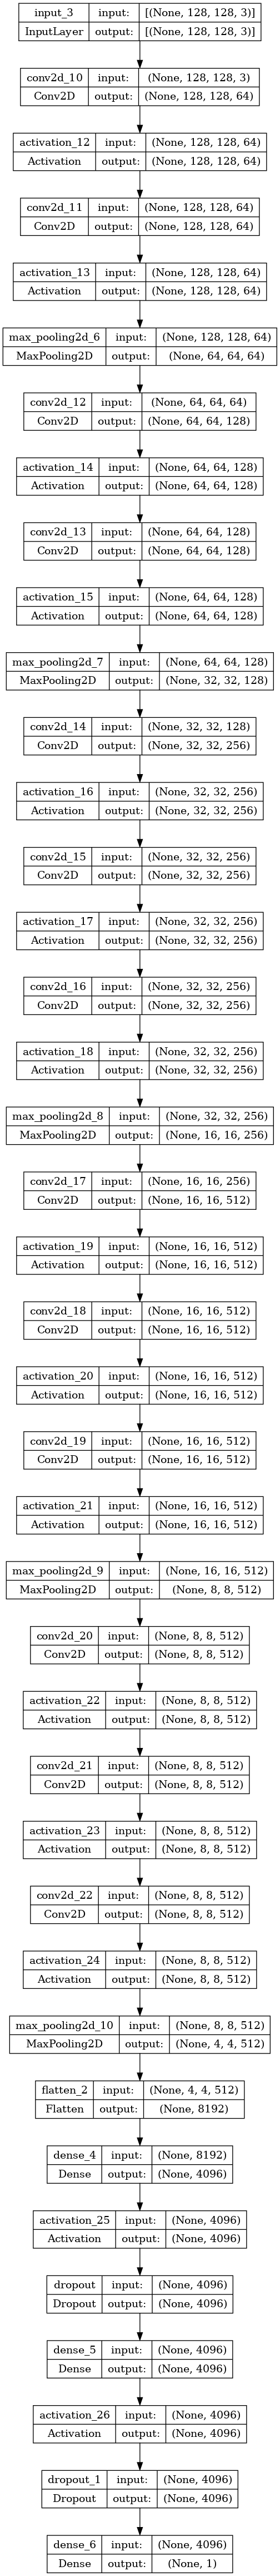

In [30]:
# Use function to create a model
model = VGG16_S(input_shape=(128, 128, 3), num_classes=1)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

## Training???

Training a VGG16 model or any other deep learning model from scratch on a small dataset can present several issues:

1. **Overfitting:** Deep learning models have millions of parameters. If the dataset is small, the model may end up memorizing the training data instead of learning generalized features, leading to poor performance on unseen data.

2. **Computational Expense:** VGG16 is a large model with approximately 138 million parameters. Training such a large model from scratch requires significant computational resources, which might not be feasible for everyone.

4. **Training Time:** Even with modern hardware, training a model like VGG16 from scratch can take a lot of time, especially if multiple epochs are needed.

### So, **What is the Solution??**



## Transfer Learning?

Transfer learning is a machine learning technique where knowledge gained from solving one problem is applied to a different but related problem. It's like using past experience to help with a new task.

Think of it this way: you know how to ride a bicycle and you have been doing it for years. Now, if you want to learn how to ride a motorcycle, you don't start from scratch. You apply some of the skills you learned from bicycle riding to this new task. This is similar to how transfer learning works.

**How it Works:**

Transfer learning involves using a pre-trained neural network trained on a large dataset called ImageNet with 1,000 different classes. There are two main strategies:

* **Feature Extraction**: The pre-trained network's learned features are used as a starting point. Only the final layers (classifier) are replaced and trained from scratch for the new task. This allows the model to extract relevant features while utilizing the general knowledge from the pre-training on ImageNet.

* **Fine-Tuning**: In addition to replacing the final layers, a few top layers of the pre-trained network are unfrozen. These layers, along with the new classifier layers, are jointly trained using the new dataset. Fine-tuning the higher-order feature representations helps the network adapt to the specific task.

* **Full Fine-Tuning**: All layers of the pre-trained network, including the base layers used for feature extraction, are unfrozen and trained. This approach provides comprehensive adaptation but requires a larger dataset to avoid overfitting.

Transfer learning leverages the pre-trained network's understanding of diverse visual patterns to accelerate learning on new tasks, achieving better performance even with limited data.

### Pre-trained Model

In [31]:
def VGG16(input_shape=(224, 224, 3),
          num_classes=1,
          lr=0.5e-3,
          num_unfreeze=2):
    # Define input layer
    inp = Input(shape=input_shape)

    # Load pre-trained VGG16 model with imagenet weights
    base_model = tf.keras.applications.VGG16(weights='imagenet',
                                             include_top=False, # drop classifer head
                                             input_shape=input_shape)

    # Freeze or unfreeze the model
    if num_unfreeze is None:
        base_model.trainable = True  # Full fine-tuning
    else:
        base_model.trainable = False  # Freeze all layers by default
        if num_unfreeze > 0:
            # Unfreeze the specified number of layers from the end
            for layer in base_model.layers[-num_unfreeze:]:
                layer.trainable = True

    # Add custom classification layers on top
    x = base_model(inp)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    return model

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               1048704   
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
________________________________________

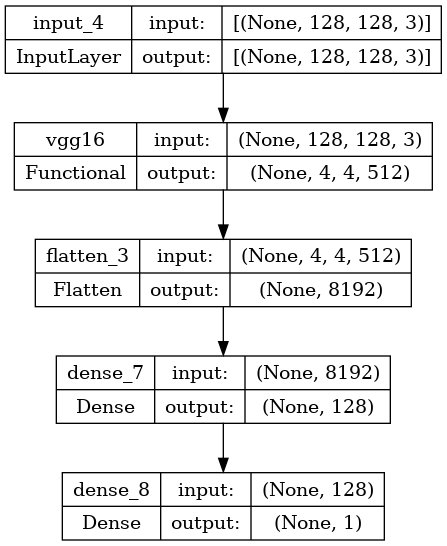

In [32]:
# Use function to create a model
model = VGG16(input_shape=(128, 128, 3), num_classes=1, num_unfreeze=5)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [33]:
# Step 1: Get train-test image paths and labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['class_label'].tolist()

valid_paths = valid_df['image_path'].tolist()
valid_labels = valid_df['class_label'].tolist()

# Step 2: Data loader
train_loader = DataLoader(train_paths, train_labels, batch_size=128, augment=False)

valid_loader = DataLoader(valid_paths, valid_labels, batch_size=128, shuffle=False)


# Step 3: Build the model
model = VGG16(input_shape=(128, 128, 3), num_classes=1, lr=0.5e-3, num_unfreeze=5)

# Step 4: Model training
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/best_vgg.h5',
                                             monitor = 'val_accuracy',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max') # to save best scoring model

print('## Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=15,
                    verbose=1,
                    callbacks=[ckpt_cb])

# Step 5: Predict on test data

## Load best model
model = tf.keras.models.load_model('/kaggle/working/best_vgg.h5') # you can save model using model.save()

print("\n## Inference")
valid_loader = DataLoader(valid_paths, valid_labels, batch_size=100, shuffle=False)
predictions = model.predict(valid_loader)[:len(valid_df)]

# Step 6: Measure performance
acc = accuracy_score(valid_labels, (predictions > 0.5).astype(int))
print(f"\n## Accuracy: {acc}")

## Training
Epoch 1/15
137/137 [==============================] - 102s 717ms/step - loss: 0.4271 - accuracy: 0.8043 - val_loss: 0.3428 - val_accuracy: 0.8488
Epoch 2/15
137/137 [==============================] - 95s 696ms/step - loss: 0.3053 - accuracy: 0.8685 - val_loss: 0.3361 - val_accuracy: 0.8546
Epoch 3/15
137/137 [==============================] - 95s 692ms/step - loss: 0.2702 - accuracy: 0.8836 - val_loss: 0.3384 - val_accuracy: 0.8522
Epoch 4/15
137/137 [==============================] - 95s 691ms/step - loss: 0.2490 - accuracy: 0.8948 - val_loss: 0.3263 - val_accuracy: 0.8587
Epoch 5/15
137/137 [==============================] - 95s 691ms/step - loss: 0.2223 - accuracy: 0.9045 - val_loss: 0.3345 - val_accuracy: 0.8579
Epoch 6/15
137/137 [==============================] - 94s 688ms/step - loss: 0.2068 - accuracy: 0.9139 - val_loss: 0.3383 - val_accuracy: 0.8567
Epoch 7/15
137/137 [==============================] - 94s 689ms/step - loss: 0.1846 - accuracy: 0.9242 - val_loss: 0.

## Plot History

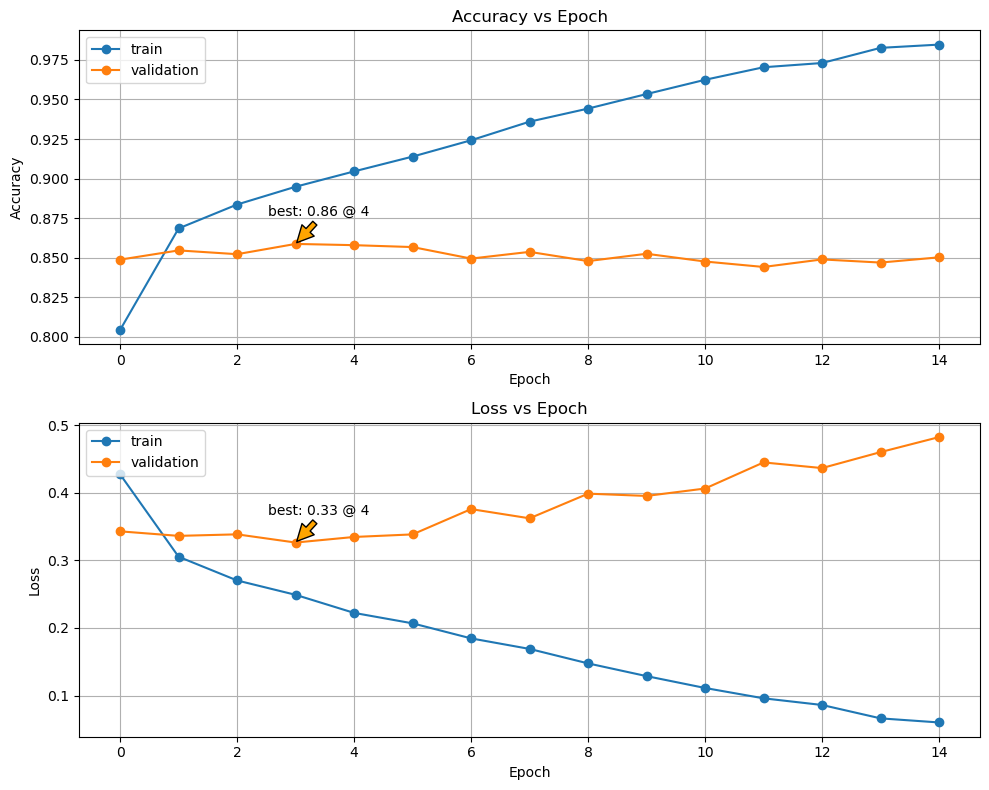

In [34]:
plot_history(history)

## Result

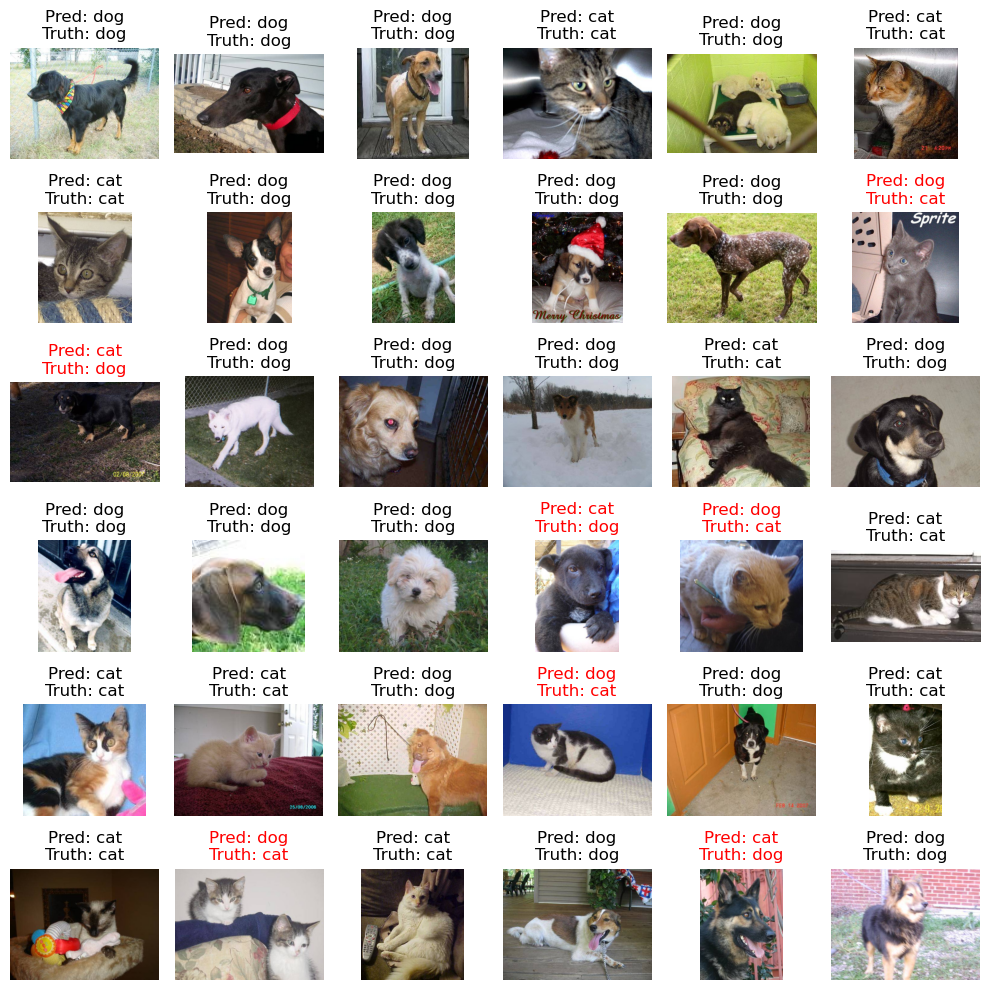

In [35]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
# indices = np.random.choice(len(valid_paths), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(range(num_images)):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image_path = valid_paths[idx]
    image = load_image(image_path)  # Load and preprocess single image
    
    # Get prediction and ground truth
    pred = (predictions[idx]>0.5).astype(int)[0]
    pred = label2name[pred] # 0 -> cat
    true = valid_labels[idx]
    true = label2name[true] # 0 -> cat

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

    if pred == true:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}')
    else:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}', color='red')

plt.tight_layout()
plt.show()


# ResNet

**Major Contributions of ResNet (Residual Network):**

1. **Residual Blocks:** ResNet introduced the concept of residual blocks with shortcut connections, allowing for networks to be deeper without suffering from the vanishing gradient problem.
2. **Extreme Depth:** ResNet has shown the importance of extreme depth in networks, with architectures spanning 34, 50, 101, and 152 layers.
3. **Achieving State-of-the-art Results:** ResNet has achieved top performance in many benchmarks and competitions, like ILSVRC 2015, thanks to its deep architecture.

**Achitecture**

<img src="https://cdn-images-1.medium.com/max/1600/1*YFlBISIjc3zbyzq0g7CPnA.png" width="300">

---

**Pros and Cons of ResNet Network:**

| Pros | Cons |
|---|---|
| Overcomes the vanishing gradient problem with residual blocks | Can be more complex to understand due to residual connections |
| Scales well with increasing depth, unlike other networks | Might be overkill for simpler, smaller datasets |
| Delivers state-of-the-art performance in various tasks | Requires considerable resources for very deep networks |
| Effective for transfer learning due to high generalization capabilities | Training deep networks can take longer time |

**VGG Vs ResNet**

| Features | VGG | ResNet |
|---|---|---|
| **Depth** | Deeper networks with 16-19 layers | Even deeper networks, up to 152 layers in some versions |
| **Architecture** | Uniform architecture using small (3x3) convolution filters | Uses 3x3 convolutions within its residual blocks, with shortcut connections |
| **Usage of ReLU** | Uses ReLU, but not the first | Continues the usage of ReLU as an activation function |
| **Size** | Larger, with around 138 million parameters in VGG16 and 144 million in VGG19 | Varies, but typically fewer parameters than VGG due to parameter sharing in residual blocks |
| **Training Speed** | Slower because of deeper architecture | Depending on the depth, can be slower or faster due to residual connections allowing for better backpropagation |
| **Transfer Learning** | Excellent for transfer learning due to better generalization of features | Also very effective for transfer learning, thanks to the learned residual functions |
| **Vanishing Gradient Problem** | Can suffer from this problem due to depth | Mitigates this issue through the use of residual blocks and shortcut connections |"



### ResBlock

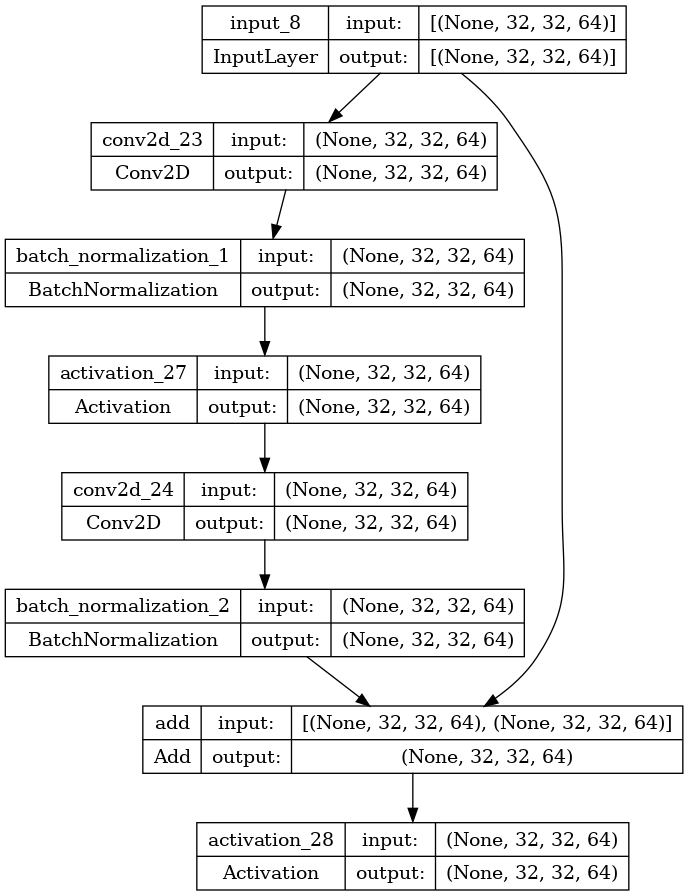

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

def ResBlock(x, filters, kernel_size):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)

    return x

input_layer = layers.Input(shape=(32, 32, 64))
output_layer = ResBlock(input_layer, 64, 3)

model = models.Model(inputs=input_layer, outputs=output_layer)

tf.keras.utils.plot_model(model, show_shapes=True)

### Pre-trained Model

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

def ResNet50(input_shape=(224, 224, 3),
             num_classes=1,
             lr=0.5e-3,
             num_unfreeze=2):
    # Define input layer
    inp = Input(shape=input_shape)

    # Load pre-trained ResNet50 model with imagenet weights
    base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                                include_top=False,
                                                input_shape=input_shape)
    

    # Freeze or unfreeze the model
    if num_unfreeze is None:
        base_model.trainable = True  # Full fine-tuning
    else:
        base_model.trainable = False  # Freeze all layers by default
        if num_unfreeze > 0:
            # Unfreeze the specified number of layers from the end
            for layer in base_model.layers[-num_unfreeze:]:
                layer.trainable = True

    # Add custom classification layers on top
    x = base_model(inp)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])
    return model


94765736/94765736 [==============================] - 4s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_11 (Dense)            (None, 128)               4194432   
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 27,782,273
Trainable params: 4,194,561
Non-trainable params: 23,587,712
________________________________________

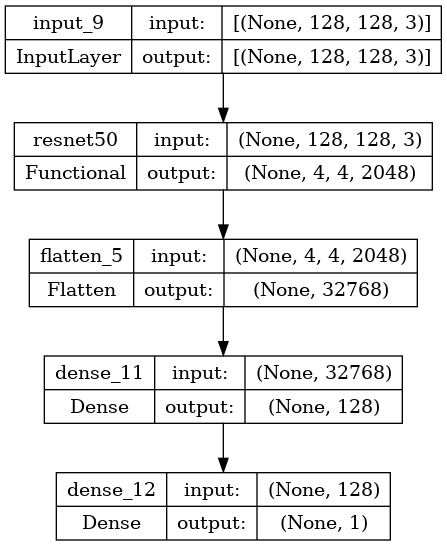

In [38]:
# Use function to create a model
model = ResNet50(input_shape=(128, 128, 3), num_classes=1, num_unfreeze=30)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [39]:
# Step 1: Get train-test image paths and labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['class_label'].tolist()

valid_paths = valid_df['image_path'].tolist()
valid_labels = valid_df['class_label'].tolist()

# Step 2: Data loader
train_loader = DataLoader(train_paths, train_labels, batch_size=128, augment=False)

valid_loader = DataLoader(valid_paths, valid_labels, batch_size=128, shuffle=False)


# Step 3: Build the model
model = ResNet50(input_shape=(128, 128, 3), num_classes=1, lr=0.5e-3, num_unfreeze=3)

# Step 4: Model training
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/best_res.h5',
                                             monitor = 'val_accuracy',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max') # to save best scoring model

print('## Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=15,
                    verbose=1,
                    callbacks=[ckpt_cb])

# Step 5: Predict on test data

## Load best model
model = tf.keras.models.load_model('/kaggle/working/best_res.h5') # you can save model using model.save()

print("\n## Inference")
valid_loader = DataLoader(valid_paths, valid_labels, batch_size=100, shuffle=False)
predictions = model.predict(valid_loader)[:len(valid_df)]

# Step 6: Measure performance
acc = accuracy_score(valid_labels, (predictions > 0.5).astype(int))
print(f"\n## Accuracy: {acc}")

## Training
Epoch 1/15
137/137 [==============================] - 100s 696ms/step - loss: 0.6892 - accuracy: 0.6288 - val_loss: 0.6967 - val_accuracy: 0.5054
Epoch 2/15
137/137 [==============================] - 95s 690ms/step - loss: 0.5568 - accuracy: 0.7158 - val_loss: 0.6739 - val_accuracy: 0.5425
Epoch 3/15
137/137 [==============================] - 95s 691ms/step - loss: 0.5340 - accuracy: 0.7335 - val_loss: 0.5794 - val_accuracy: 0.7169
Epoch 4/15
137/137 [==============================] - 95s 690ms/step - loss: 0.5226 - accuracy: 0.7393 - val_loss: 0.5449 - val_accuracy: 0.7278
Epoch 5/15
137/137 [==============================] - 95s 690ms/step - loss: 0.5014 - accuracy: 0.7551 - val_loss: 0.5314 - val_accuracy: 0.7414
Epoch 6/15
137/137 [==============================] - 95s 688ms/step - loss: 0.4929 - accuracy: 0.7593 - val_loss: 0.5261 - val_accuracy: 0.7438
Epoch 7/15
137/137 [==============================] - 94s 684ms/step - loss: 0.4787 - accuracy: 0.7703 - val_loss: 0.

## Plot History

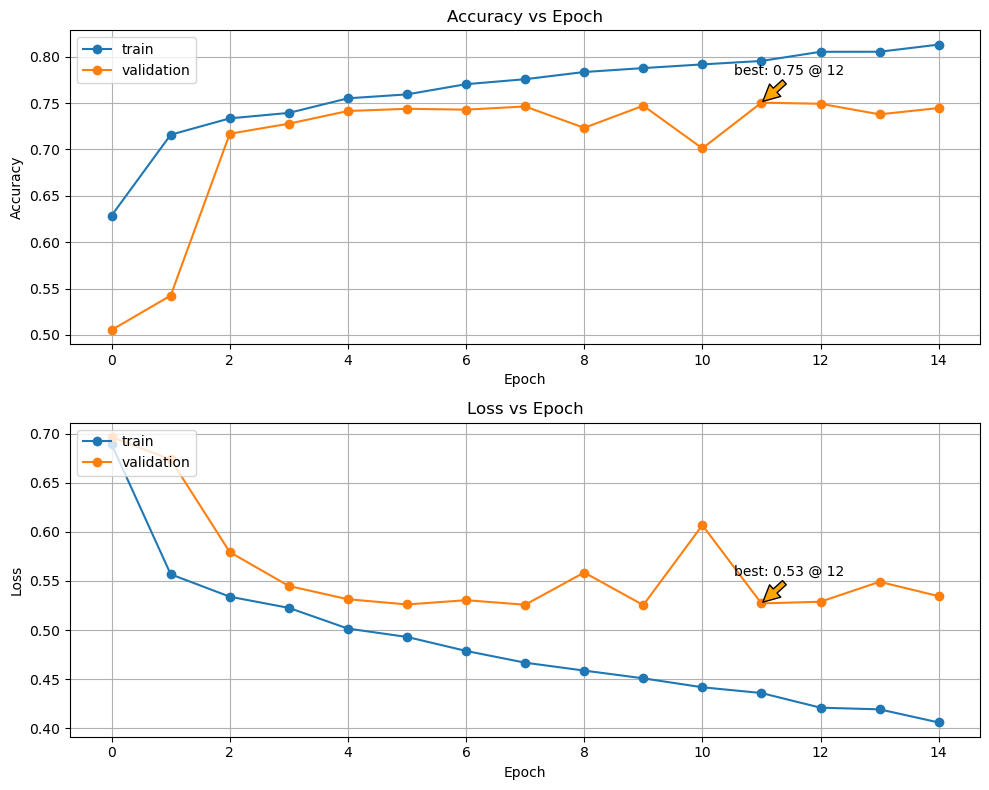

In [40]:
plot_history(history)

## Result

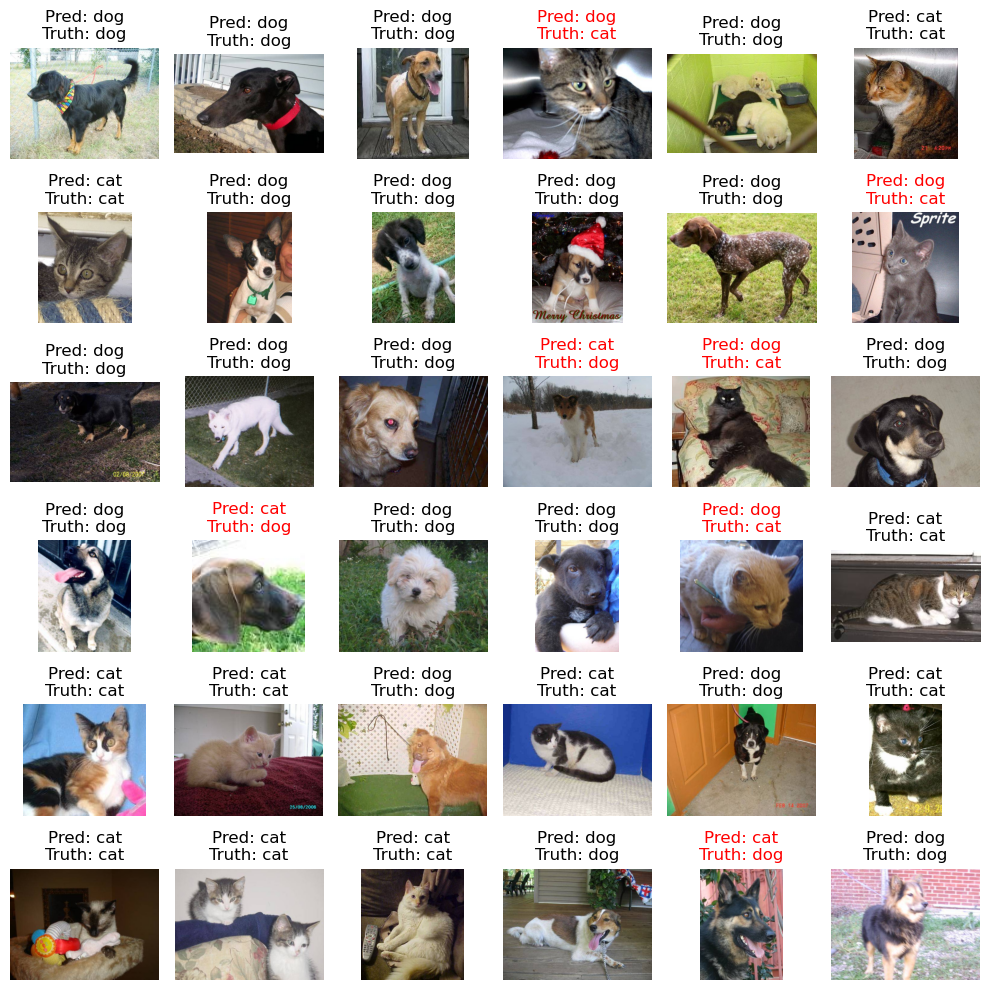

In [41]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
# indices = np.random.choice(len(valid_paths), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(range(num_images)):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image_path = valid_paths[idx]
    image = load_image(image_path)  # Load and preprocess single image
    
    # Get prediction and ground truth
    pred = (predictions[idx]>0.5).astype(int)[0]
    pred = label2name[pred] # 0 -> cat
    true = valid_labels[idx]
    true = label2name[true] # 0 -> cat

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

    if pred == true:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}')
    else:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}', color='red')

plt.tight_layout()
plt.show()


# InceptionNet

**Major Contributions of InceptionNet:**

1. **Efficient Inception Modules:** InceptionNet introduced the inception module, which enabled it to learn multi-level features in the same layer. This improved performance while also reducing computational cost.
2. **Depth and Width Importance:** InceptionNet showed that increasing the depth and width of the network, within the limits of the available computational budget, improves performance.
3. **Auxiliary Classifiers:** InceptionNet used auxiliary classifiers to combat the vanishing gradients problem, which allowed it to successfully train deeper networks.

**Architecture**

<img src="https://miro.medium.com/max/1400/1*DKjGRDd_lJeUfVlY50ojOA.png" width="700">

---

**Pros and Cons of InceptionNet:**

| Pros | Cons |
|---|---|
| Introduced the efficient Inception modules | More complex architecture compared to other networks |
| Managed to increase depth and width of network without significant computational cost | Requires careful tuning and is more prone to overfitting |
| Auxiliary classifiers help in training deeper networks | While it performs well on larger datasets, it may not generalize well to smaller ones |
| Achieved state-of-the-art performance on image classification tasks | The complexity makes the network harder to modify and adapt |


### InceptionBlock

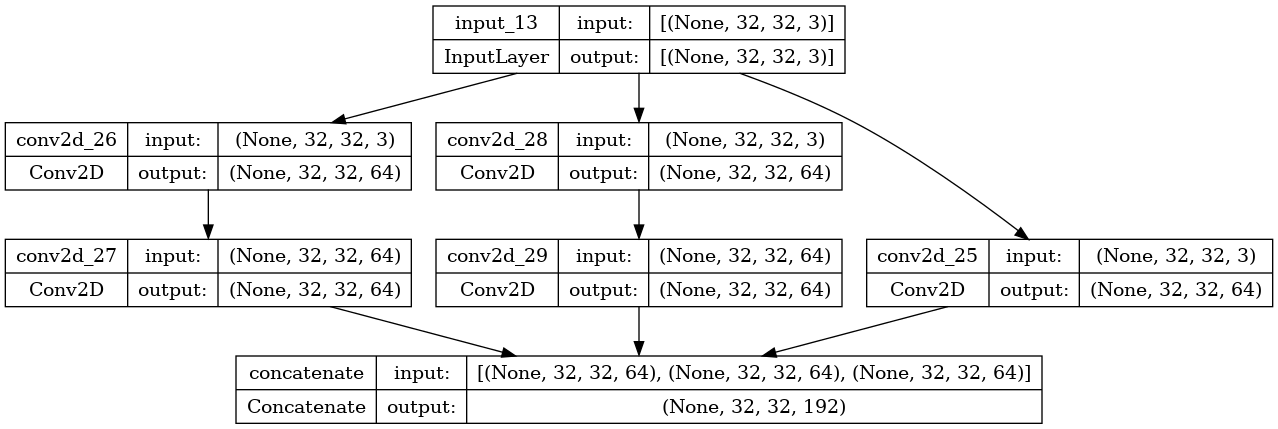

In [42]:
from tensorflow.keras import layers

def InceptionBlock(x, filters):
    path1 = layers.Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(x)

    path2 = layers.Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(path2)

    path3 = layers.Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')(path3)
    
#     path4 = layers.MaxPool2D((3,3))(x)

    output = layers.concatenate([path1, path2, path3], axis=-1)
    return output

input_layer = layers.Input(shape=(32, 32, 3))
output_layer = InceptionBlock(input_layer, 64)

model = models.Model(inputs=input_layer, outputs=output_layer)
tf.keras.utils.plot_model(model, show_shapes=True)

# DenseNet

**Major Contributions of DenseNet:**

1. **Dense Connectivity:** DenseNet introduced a novel architecture where each layer is connected to every other layer in a feed-forward fashion. This allows for efficient feature reuse, thus improving performance and reducing the number of parameters.
2. **Feature Reuse:** DenseNet significantly reduces the number of parameters and computational cost, making it more efficient than traditional architectures.
3. **Alleviation of Vanishing-Gradient Problem:** The dense connectivity facilitates the propagation of gradients throughout the network, which helps alleviate the vanishing-gradient problem and aids in deep network training.

**Architecture**

<img src="https://pytorch.org/assets/images/densenet1.png" width="500">

---

**Pros and Cons of DenseNet:**

| Pros | Cons |
|---|---|
| Dense connectivity leads to efficient feature reuse | The architecture can lead to a high computational cost in terms of memory usage |
| Requires fewer parameters, making it computationally efficient | Dense connections might not always improve performance and could make the model complex |
| Alleviates the vanishing-gradient problem | Although the model is more parameter-efficient, it still requires a lot of computational resources for large scale datasets |
| Achieved state-of-the-art performance on image classification tasks | The model's complexity can make it harder to implement and modify |

### DenseBlock

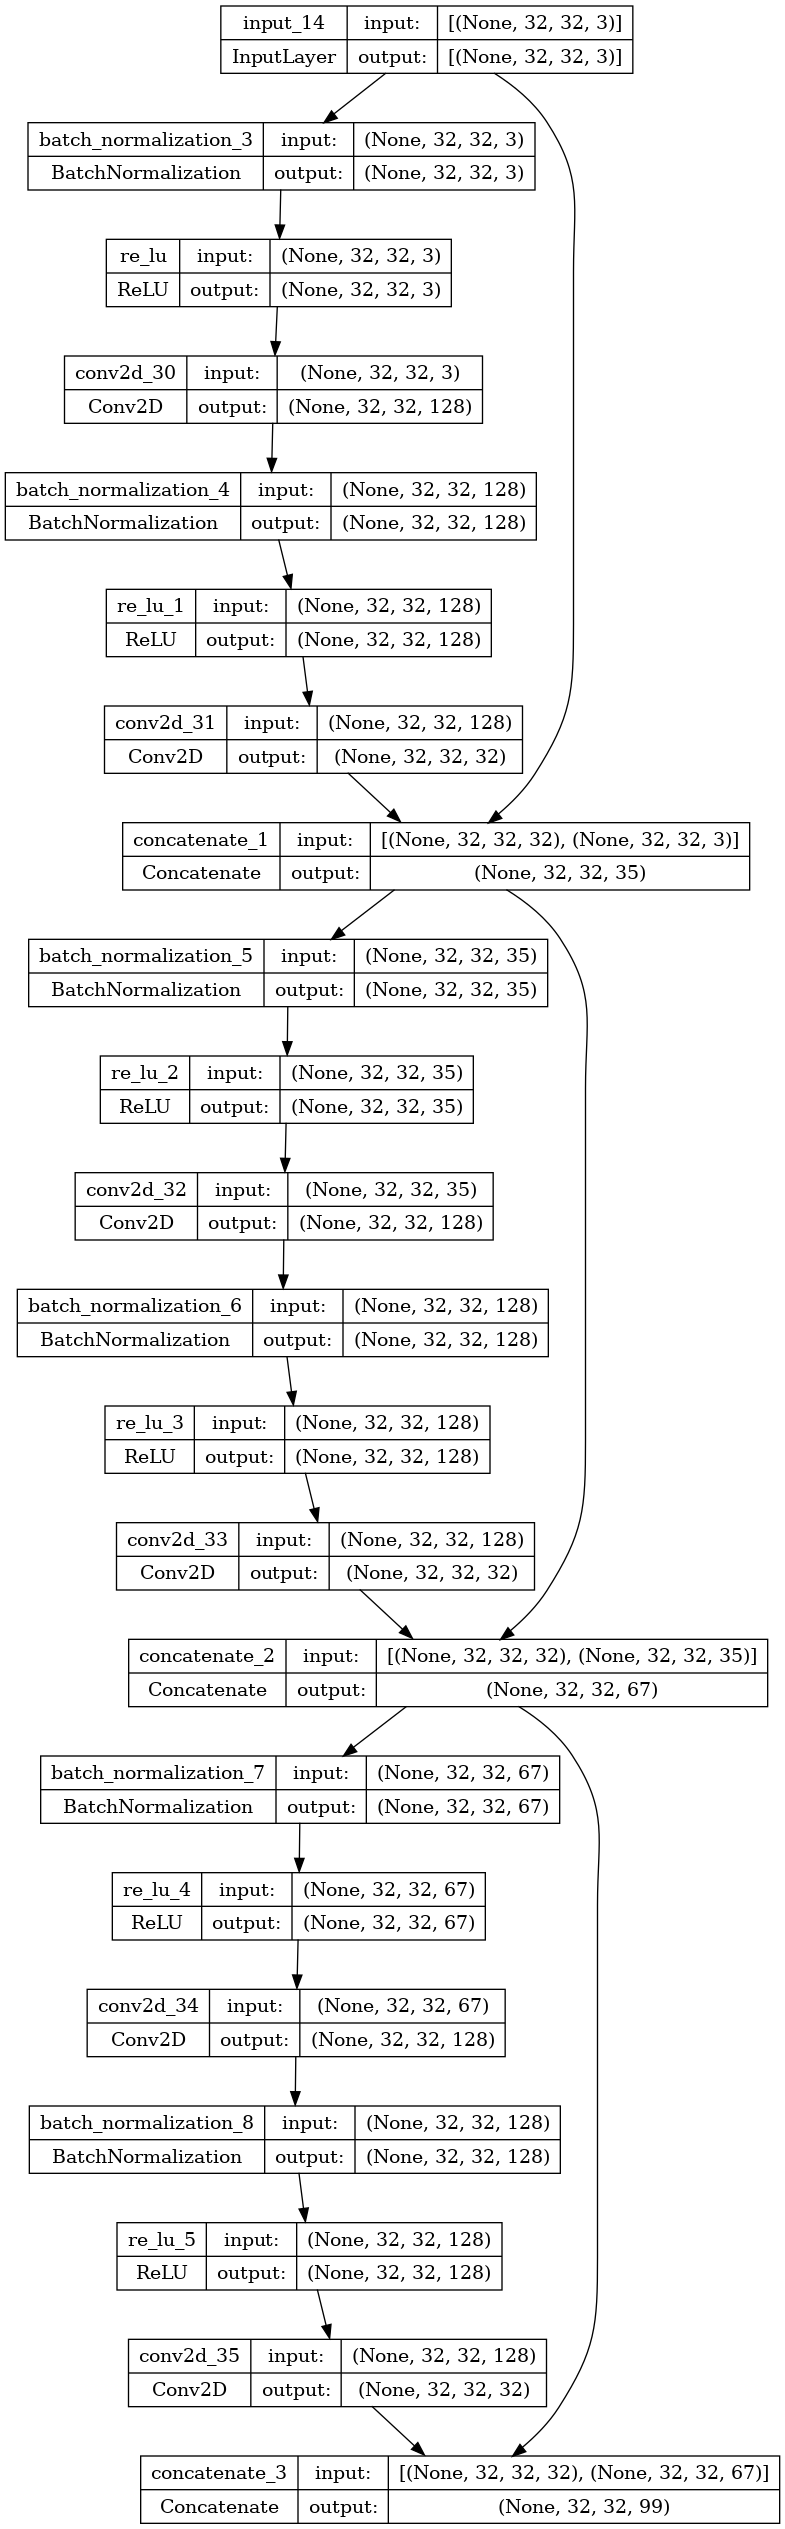

In [43]:
from tensorflow.keras import layers, models

def conv_layer(x, filters, kernel=1, strides=1):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Conv2D(filters, kernel, strides=strides, padding="same")(x)
    return x

def DenseBlock(x, repetition,filters):
    for _ in range(repetition):
        y = conv_layer(x, 4 * filters)
        y = conv_layer(y, filters, 3)
        x = layers.concatenate([y, x])
    return x

input_layer = layers.Input(shape=(32, 32, 3))
output_layer = DenseBlock(input_layer, 3, 32)

model = models.Model(inputs=input_layer, outputs=output_layer)

tf.keras.utils.plot_model(model, show_shapes=True)
